In [1]:
!pip install -q -r ../requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

In [59]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, accuracy_score
from sklearn.inspection import permutation_importance
import shap
from tqdm import tqdm
import warnings
import joblib
import gc
from pprint import pprint

In [4]:
sys.path.append("../src")
from utils import *

In [5]:
warnings.simplefilter("ignore")

In [6]:
pd.set_option("display.max_columns", None)

In [7]:
df_attrition = pd.read_csv("../cortAIx Factory Data Science Technical Test project #1.csv")
df_attrition.head()

,Unnamed: 0,Employee_ID,Age,Gender,Department,Job_Title,Office_Localisation,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
0,0,0,27.0,Male,Marketing,Manager,New York,9.0,0.586251,151,0,60132,0.0
1,1,1,53.0,Female,Sales,Engineer,New York,10.0,0.261161,221,1,79947,0.0
2,2,2,59.0,Female,Marketing,Analyst,New York,8.0,0.304382,184,0,46958,1.0
3,3,3,42.0,Female,Engineering,Manager,New York,1.0,0.480779,242,0,40662,0.0
4,4,4,44.0,Female,Sales,Engineer,New York,10.0,0.636244,229,1,74307,0.0


In [8]:
df_attrition=df_attrition.iloc[:, 2:]
df_attrition.head()

,Age,Gender,Department,Job_Title,Office_Localisation,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
0,27.0,Male,Marketing,Manager,New York,9.0,0.586251,151,0,60132,0.0
1,53.0,Female,Sales,Engineer,New York,10.0,0.261161,221,1,79947,0.0
2,59.0,Female,Marketing,Analyst,New York,8.0,0.304382,184,0,46958,1.0
3,42.0,Female,Engineering,Manager,New York,1.0,0.480779,242,0,40662,0.0
4,44.0,Female,Sales,Engineer,New York,10.0,0.636244,229,1,74307,0.0


In [9]:
df_attrition.shape

(1005, 11)

In [10]:
df_attrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    1002 non-null   float64
 1   Gender                 1005 non-null   object 
 2   Department             1003 non-null   object 
 3   Job_Title              1003 non-null   object 
 4   Office_Localisation    1005 non-null   object 
 5   Years_at_Company       1003 non-null   float64
 6   Satisfaction_Level     1005 non-null   float64
 7   Average_Monthly_Hours  1005 non-null   object 
 8   Promotion_Last_5Years  1005 non-null   int64  
 9   Salary                 1005 non-null   int64  
 10  Attrition              1003 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 86.5+ KB


In [11]:
df_attrition.describe()

,Age,Years_at_Company,Satisfaction_Level,Promotion_Last_5Years,Salary,Attrition
count,1002.000000,1003.000000,1005.000000,1005.000000,1005.000000,1003.000000
mean,42.159681,5.788550,0.853978,77.989055,64364.466667,0.493519
std,10.003219,5.038546,7.786145,1758.286034,20707.140455,0.500207
min,25.000000,0.000000,0.001376,0.000000,0.000000,0.000000
25%,33.000000,3.000000,0.261064,0.000000,47576.000000,0.000000
50%,43.000000,6.000000,0.505940,0.000000,64407.000000,0.000000
75%,50.000000,8.000000,0.762460,1.000000,81919.000000,1.000000
max,59.000000,99.000000,177.000000,45124.000000,99991.000000,1.000000


In [12]:
df_attrition.head()

,Age,Gender,Department,Job_Title,Office_Localisation,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
0,27.0,Male,Marketing,Manager,New York,9.0,0.586251,151,0,60132,0.0
1,53.0,Female,Sales,Engineer,New York,10.0,0.261161,221,1,79947,0.0
2,59.0,Female,Marketing,Analyst,New York,8.0,0.304382,184,0,46958,1.0
3,42.0,Female,Engineering,Manager,New York,1.0,0.480779,242,0,40662,0.0
4,44.0,Female,Sales,Engineer,New York,10.0,0.636244,229,1,74307,0.0


# Statistics

## Categorical Data

In [13]:
df_attrition["Gender"].value_counts(normalize=True, dropna=False)

Gender
Male      0.506468
Female    0.493532
Name: proportion, dtype: float64

In [14]:
df_attrition["Department"].value_counts(normalize=True, dropna=False)

Department
Sales          0.208955
Finance        0.205970
Engineering    0.203980
HR             0.190050
Marketing      0.189055
NaN            0.001990
Name: proportion, dtype: float64

In [15]:
df_attrition["Job_Title"].value_counts(normalize=True, dropna=False)

Job_Title
Engineer         0.213930
Accountant       0.206965
Manager          0.203980
Analyst          0.193035
HR Specialist    0.178109
NaN              0.001990
1                0.000995
2                0.000995
Name: proportion, dtype: float64

In [16]:
df_attrition["Office_Localisation"].value_counts(normalize=True, dropna=False)

Office_Localisation
New York    1.0
Name: proportion, dtype: float64

In [17]:
df_attrition["Promotion_Last_5Years"].value_counts(normalize=True, dropna=False)

Promotion_Last_5Years
0        0.515423
1        0.482587
45124    0.000995
32770    0.000995
Name: proportion, dtype: float64

Most categorical data are uniformly distributed, with some of the following issues:
- Missing values in Department
- Missing values in Job_Title
- Outliers in Job_Title (values 1 and 2)
- Outliers in Promotion_Last_5Years (values 45124 and 32770)

In [18]:
mask_categorical = (
    df_attrition["Department"].isnull() |
    df_attrition["Job_Title"].isnull() |
    df_attrition["Job_Title"].isin(["1", "2"]) |
    df_attrition["Promotion_Last_5Years"].isin([45124, 32770])
)

## Numerical Data

In [19]:
# We check for missing values
df_attrition[["Age", "Years_at_Company",
             "Satisfaction_Level", "Average_Monthly_Hours",
             "Salary"]].isnull().sum()

Age                      3
Years_at_Company         2
Satisfaction_Level       0
Average_Monthly_Hours    0
Salary                   0
dtype: int64

In [20]:
# We check for not consistent data
df_attrition[df_attrition["Age"] < df_attrition["Years_at_Company"]]

,Age,Gender,Department,Job_Title,Office_Localisation,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
206,26.0,Female,Engineering,Engineer,New York,99.0,0.870157,168,0,30773,0.0
770,32.0,Male,Engineering,Analyst,New York,99.0,0.471630,163,0,60017,1.0


In [21]:
# We also check for 0 salaries to look for outliers
df_attrition[df_attrition["Salary"]==0]

,Age,Gender,Department,Job_Title,Office_Localisation,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
47,39.0,Female,NaN,1,New York,0.198641,177.000000,1,45124,0,NaN
538,38.0,Male,Engineering,Engineer,New York,3.000000,0.968685,232,0,0,0.0
566,48.0,Female,Engineering,Accountant,New York,7.000000,0.252085,232,0,0,0.0
862,35.0,Female,Engineering,Accountant,New York,9.000000,0.719021,213,1,0,0.0


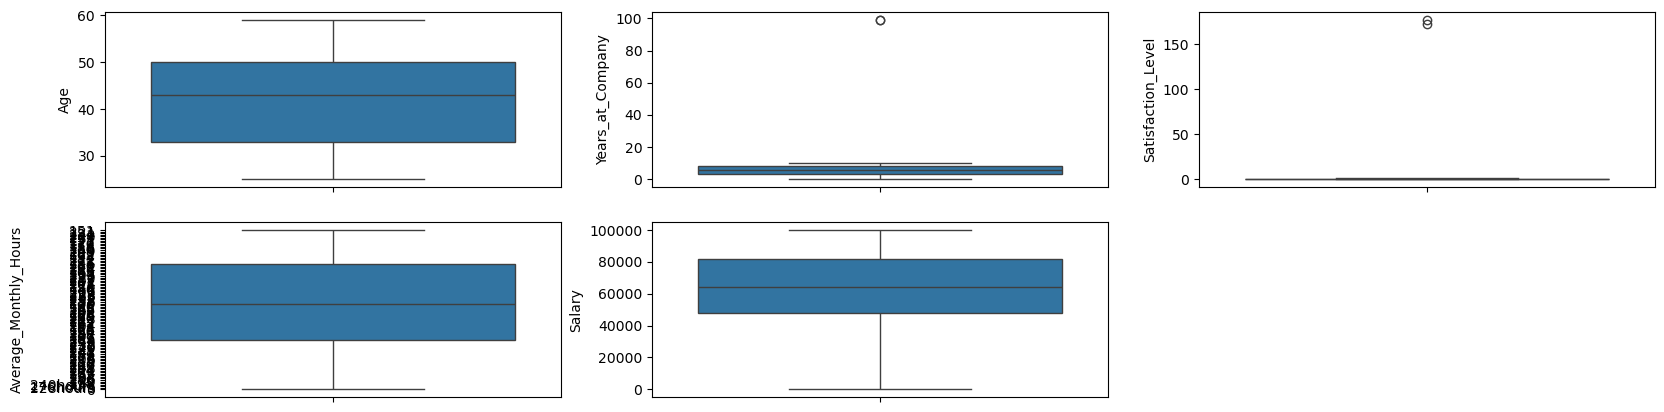

In [22]:
# We check for outliers using boxplot
fig, axes = plt.subplots(2, 3, figsize=(20, 5))
axes[1, 2].remove()
axes = axes.flatten()

for i, col in enumerate(["Age", "Years_at_Company", "Satisfaction_Level",
                        "Average_Monthly_Hours", "Salary"]):
    plt.sca(axes[i])
    sns.boxplot(y=df_attrition[col])

- Variables Years_at_Company and Satisfaction_Level present some outliers as seen in the boxplots respectively for over 90 and over 150
- Salaries equal to 0 are for employees being in the company for more than 3 years, which is weird

In [23]:
mask_numerical = (
    df_attrition["Age"].isnull() |
    df_attrition["Years_at_Company"].isnull() |
    (df_attrition["Age"] < df_attrition["Years_at_Company"]) |
    (df_attrition["Years_at_Company"] > 90) |
    (df_attrition["Satisfaction_Level"] > 150) |
    (df_attrition["Salary"] == 0)
)

## Target

In [24]:
df_attrition["Attrition"].value_counts(normalize=True, dropna=False)

Attrition
0.0    0.505473
1.0    0.492537
NaN    0.001990
Name: proportion, dtype: float64

The data is not imbalanced, we will not need to use techniques like SMOTE or ADASYN, or change the losses of the classification algorithms.

However, the target has some missing values.

In [25]:
mask_target = df_attrition["Attrition"].isnull()

## Dealing with missing values and outliers

In [26]:
len(df_attrition[mask_categorical | mask_numerical | mask_target])/len(df_attrition)

0.013930348258706468

In [27]:
# We drop rows with missing values as they only reprsent 1% of the dataset
df_attrition = df_attrition[~(mask_categorical | mask_numerical | mask_target)]

# We can also drop the Office_Localisation column as it only has one category
df_attrition.drop(columns="Office_Localisation", inplace = True)

df_attrition.head()

,Age,Gender,Department,Job_Title,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
0,27.0,Male,Marketing,Manager,9.0,0.586251,151,0,60132,0.0
1,53.0,Female,Sales,Engineer,10.0,0.261161,221,1,79947,0.0
2,59.0,Female,Marketing,Analyst,8.0,0.304382,184,0,46958,1.0
3,42.0,Female,Engineering,Manager,1.0,0.480779,242,0,40662,0.0
4,44.0,Female,Sales,Engineer,10.0,0.636244,229,1,74307,0.0


## Data Preprocessing

In [28]:
# We fix data types
df_attrition.dtypes

Age                      float64
Gender                    object
Department                object
Job_Title                 object
Years_at_Company         float64
Satisfaction_Level       float64
Average_Monthly_Hours     object
Promotion_Last_5Years      int64
Salary                     int64
Attrition                float64
dtype: object

In [29]:
df_attrition["Average_Monthly_Hours"].unique()

array(['151', '221', '184', '242', '229', '237', '155', '171', '177',
       '170', '178', '158', '180', '249', '199', '222', '169', '193',
       '154', '211', '172', '191', '216', '160', '162', '224', '156',
       '183', '194', '203', '220', '247', '201', '161', '214', '226',
       '153', '186', '200', '217', '228', '223', '209', '233', '238',
       '236', '173', '196', '195', '165', '245', '202', '212', '168',
       '185', '225', '190', '218', '227', '192', '167', '204', '157',
       '163', '176', '150', '244', '187', '207', '182', '189', '239',
       '246', '232', '235', '210', '240', '175', '241', '243', '181',
       '159', '215', '206', '188', '219', '213', '166', '231', '248',
       '164', '174', '234', '152', '197', '208', '205', '179', '230',
       '198', '240hours', '176hours', '228hours'], dtype=object)

In [30]:
df_attrition["Average_Monthly_Hours"]=df_attrition["Average_Monthly_Hours"].apply(lambda x: int(keep_only_digits(x)))

In [31]:
df_attrition["Average_Monthly_Hours"].unique()

array([151, 221, 184, 242, 229, 237, 155, 171, 177, 170, 178, 158, 180,
       249, 199, 222, 169, 193, 154, 211, 172, 191, 216, 160, 162, 224,
       156, 183, 194, 203, 220, 247, 201, 161, 214, 226, 153, 186, 200,
       217, 228, 223, 209, 233, 238, 236, 173, 196, 195, 165, 245, 202,
       212, 168, 185, 225, 190, 218, 227, 192, 167, 204, 157, 163, 176,
       150, 244, 187, 207, 182, 189, 239, 246, 232, 235, 210, 240, 175,
       241, 243, 181, 159, 215, 206, 188, 219, 213, 166, 231, 248, 164,
       174, 234, 152, 197, 208, 205, 179, 230, 198])

In [32]:
df_attrition["Attrition"]=df_attrition["Attrition"].apply(int)

In [33]:
df_attrition.head()

,Age,Gender,Department,Job_Title,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
0,27.0,Male,Marketing,Manager,9.0,0.586251,151,0,60132,0
1,53.0,Female,Sales,Engineer,10.0,0.261161,221,1,79947,0
2,59.0,Female,Marketing,Analyst,8.0,0.304382,184,0,46958,1
3,42.0,Female,Engineering,Manager,1.0,0.480779,242,0,40662,0
4,44.0,Female,Sales,Engineer,10.0,0.636244,229,1,74307,0


In [34]:
categorical_columns = ["Gender", "Department", "Job_Title", "Promotion_Last_5Years"]
numerical_columns = ["Age", "Years_at_Company", "Satisfaction_Level", "Average_Monthly_Hours", "Salary"]
target_column = ["Attrition"]

## Distributions

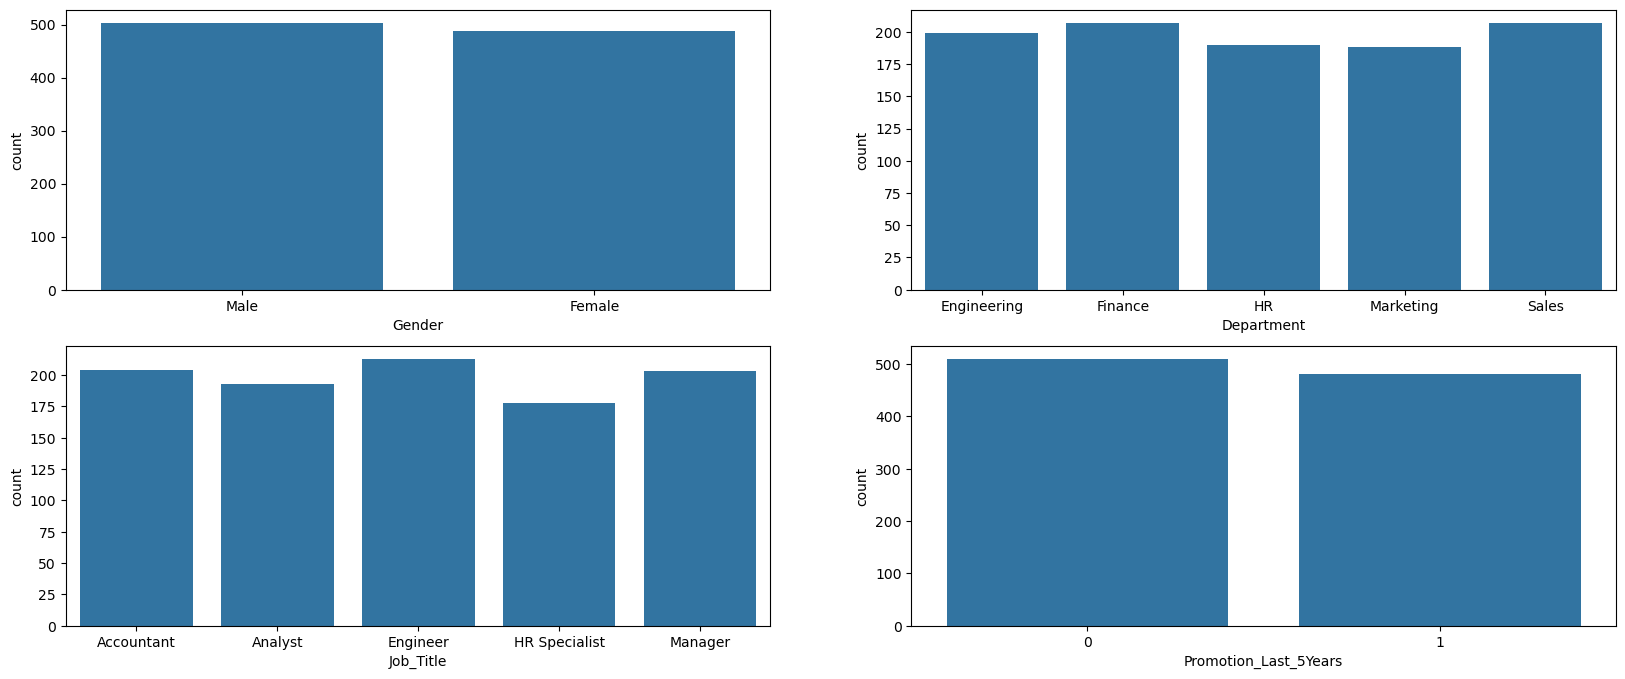

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    plt.sca(axes[i])
    sns.countplot(data=df_attrition,
                 x=col)

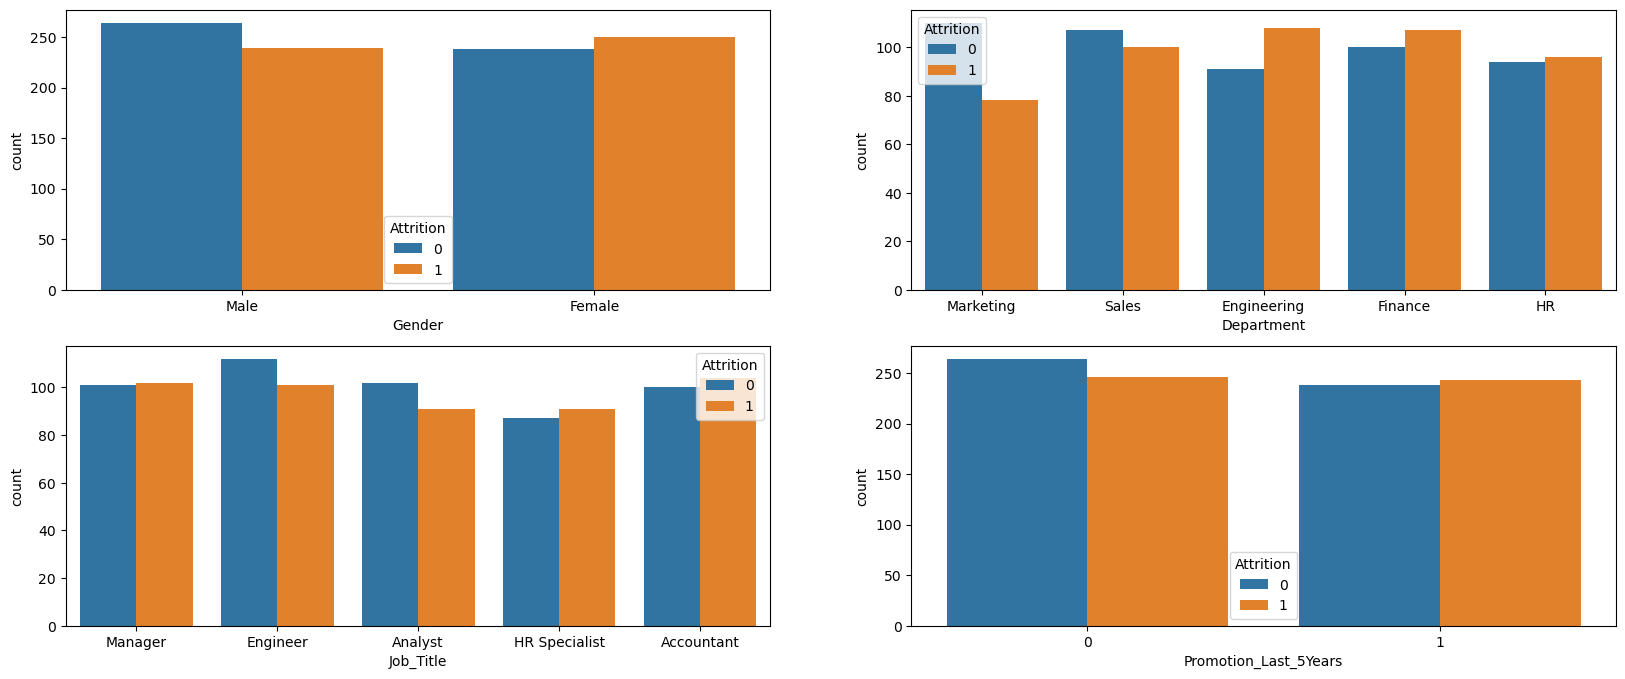

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    plt.sca(axes[i])
    sns.countplot(data=df_attrition,
                 x=col,
                 hue="Attrition")

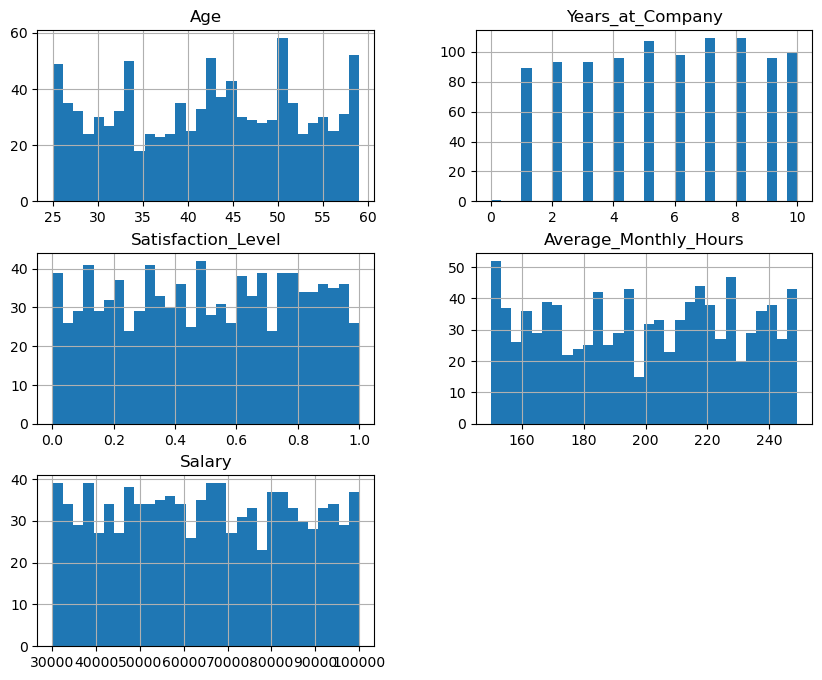

In [36]:
_ = df_attrition[numerical_columns].hist(figsize=(10, 8), bins=30)

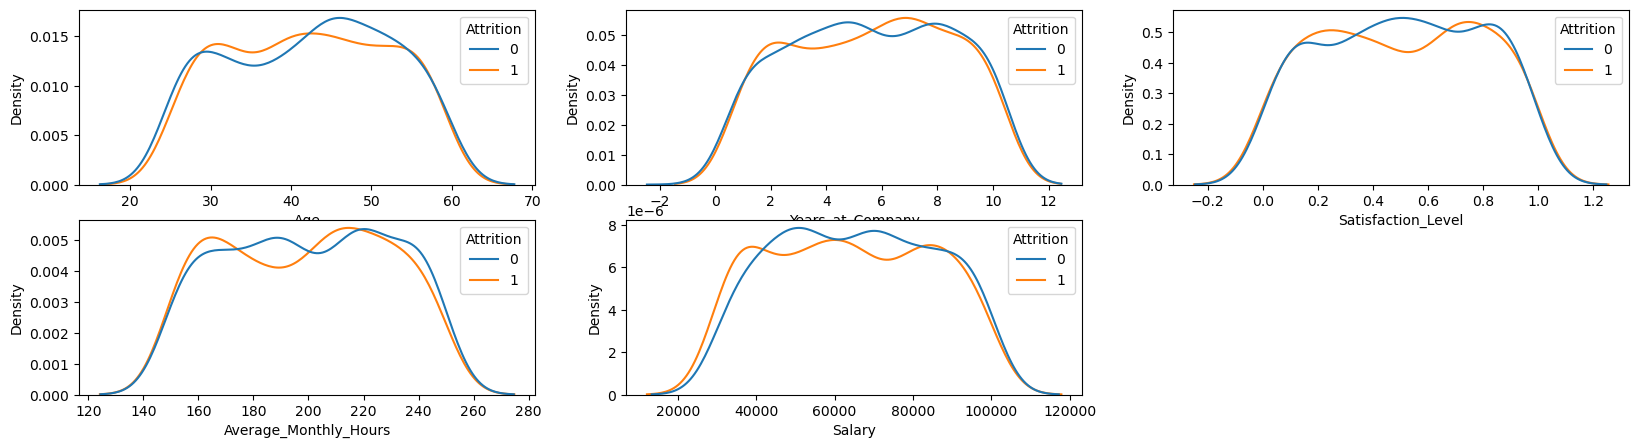

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(20, 5))
axes[1,2].remove()
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    plt.sca(axes[i])
    sns.kdeplot(data=df_attrition,
                 x=col,
                 hue="Attrition")

## Correlations

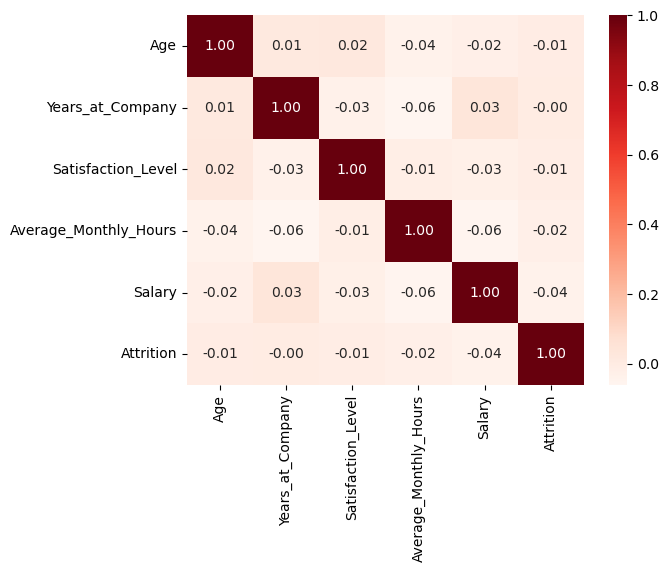

In [38]:
_ = sns.heatmap(df_attrition[numerical_columns + target_column].corr(),
               annot=True,
               cmap="Reds",
               fmt=".2f")

## Feature Engineering

### Numerical Variables binning

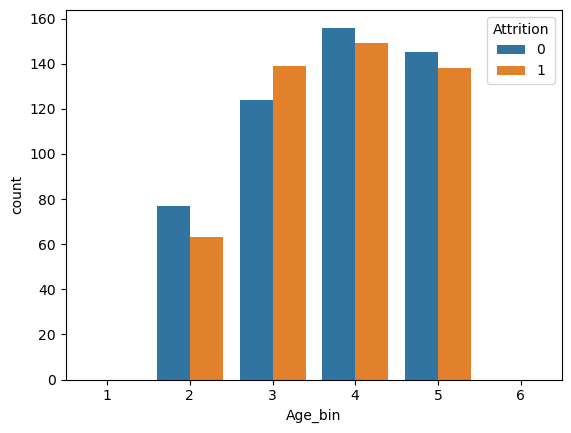

In [39]:
# We discretize Age variables into age bins
bins = [0, 18, 30, 40, 50, 60, 100]
labels = [1, 2, 3, 4, 5, 6]

df_attrition["Age_bin"]=pd.cut(df_attrition["Age"], bins=bins, labels=labels, right=False)

_=sns.countplot(data=df_attrition,
                 x="Age_bin",
                 hue="Attrition")

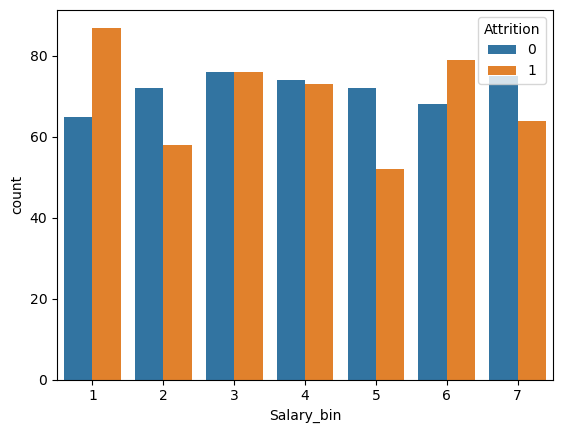

In [40]:
# We discretize Salary variable by bins of 10000
bins = list(range(30000, 110000, 10000))
labels = [i+1 for i in range(len(bins)-1)]

df_attrition["Salary_bin"]=pd.cut(df_attrition["Salary"], bins=bins, labels=labels, right=False)

_=sns.countplot(data=df_attrition,
                 x="Salary_bin",
                 hue="Attrition")

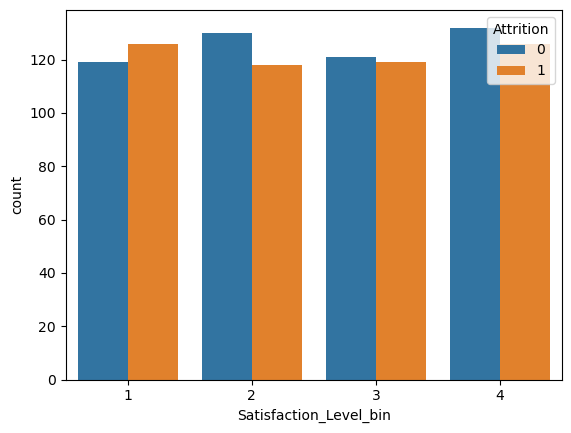

In [41]:
# We discretize Satisfaction_Level variable 
bins = [0, .25, .5, .75, 1]
labels = [1, 2, 3, 4]

df_attrition["Satisfaction_Level_bin"]=pd.cut(df_attrition["Satisfaction_Level"], bins=bins, labels=labels, right=False)

_=sns.countplot(data=df_attrition,
                 x="Satisfaction_Level_bin",
                 hue="Attrition")

### Categorical variables interaction

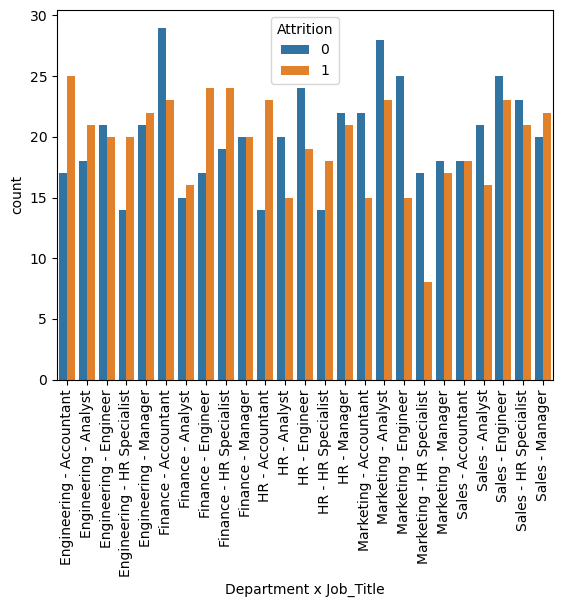

In [42]:
df_attrition["Department x Job_Title"] = df_attrition["Department"] + " - " + df_attrition["Job_Title"]
df_attrition.sort_values(by = "Department x Job_Title", ascending = True, inplace = True)
_ =  sns.countplot(data=df_attrition,
                   x="Department x Job_Title",
                   hue="Attrition")
_ = plt.xticks(rotation=90)

This interaction term brings the same information as a breakdown by Department, it seems like the Department is more important for attrition than job title and interaction term.

# Classification pipeline

## Model Selection by Cross Validation

In [148]:
# We try to make the data more gaussian
pipeline_1 = make_pipeline(
    PowerTransformer(),
    StandardScaler()
)

pipeline_2 = make_pipeline(
    OneHotEncoder(drop="first", handle_unknown="ignore")
)

pipeline_3 = make_pipeline(
    TargetEncoder(),
    StandardScaler()
)

preprocessor = ColumnTransformer(
    transformers = [
        ("power_transformer_scaler", pipeline_1, ["Age", "Years_at_Company", "Average_Monthly_Hours", "Salary", "Satisfaction_Level"]),
        ("one_hot_encoder", pipeline_2, ["Gender"]),
        ("target_encoder_scaler", pipeline_3, ["Department"]),
        ("passthrough", "passthrough", ["Promotion_Last_5Years"])
    ]
)

In [149]:
# We define classifiers
dict_classifiers = {
    "Logistic Regression":LogisticRegression(),
    "Ridge Regression":LogisticRegression(penalty='l2', solver='lbfgs', C=1.0),
    "Lasso Regression":LogisticRegression(penalty='l1', solver='liblinear', C=1.0),
    "ElasticNet Regression":LogisticRegression(penalty='elasticnet', solver='saga', C=1.0, l1_ratio=0.5),
    "Random Forest":RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Linear SVM": SVC(kernel="linear", probability=True),
    "RBF SVM":SVC(kernel="rbf", probability=True),
    "Gradient Boosting":GradientBoostingClassifier(),
    "XGB":XGBClassifier(),
    "LGBM":LGBMClassifier(verbose=-1),
    "MLP":MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500),
    "Gaussian Naive Bayes":GaussianNB(),
    "Bernoulli Naive Bayes":BernoulliNB(),
    "Bagging":BaggingClassifier(),
    "Voting":VotingClassifier(estimators=[('rf', RandomForestClassifier()), ('xgb', XGBClassifier())], voting='soft'),
    "KNN":KNeighborsClassifier(n_neighbors=5),
    "Quadratic Discriminant Analysis":QuadraticDiscriminantAnalysis()
}

dict_recalls = {}

for name, classifier in tqdm(dict_classifiers.items()):
    
    # We create the final pipeline (preprocessing + classifier)
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", classifier)
    ])
    
    # We apply cross validation and compute mean recall
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    scores = cross_val_score(pipeline,
                            df_attrition.drop(columns=["Attrition"]),
                            df_attrition["Attrition"],
                            cv=cv,
                            scoring="recall",
                            error_score="raise")

    dict_recalls[name]=float(np.mean(scores))

100%|██████████| 19/19 [00:12<00:00,  1.51it/s]


In [150]:
dict(sorted(dict_recalls.items(), key=lambda item: item[1]))

{'Bagging': 0.40096780980433416,
 'KNN': 0.4459078476751525,
 'MLP': 0.4601094045865769,
 'RBF SVM': 0.4661266568483063,
 'Random Forest': 0.47248053860719547,
 'Ridge Regression': 0.4786450662739322,
 'Bernoulli Naive Bayes': 0.48064380391331796,
 'Logistic Regression': 0.49101620029455084,
 'Linear Discriminant Analysis': 0.49269934778034913,
 'Lasso Regression': 0.49495055754260464,
 'XGB': 0.49896907216494846,
 'Decision Tree': 0.5010098884914791,
 'Gradient Boosting': 0.5011150852093416,
 'LGBM': 0.503197980223017,
 'ElasticNet Regression': 0.5112560488112771,
 'Quadratic Discriminant Analysis': 0.5153587208079108,
 'Voting': 0.5214180517567851,
 'Gaussian Naive Bayes': 0.5397643593519883,
 'Linear SVM': 0.6011571638964863}

## Fine tuning of the model

In [151]:
# Define the Linear SVM model
svm_model = SVC(kernel="linear", probability=True, random_state=42)

# Define the parameter grid for tuning SVM
param_grid = {
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'classifier__max_iter': [-1]  # Maximum number of iterations for convergence
}

# Create the final pipeline (preprocessing + classifier)
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", svm_model)
])

In [152]:
# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, 
                           param_grid, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True), 
                           scoring="recall")

# Fit the model with grid search
grid_search.fit(df_attrition.drop(columns=["Attrition"]), 
                df_attrition["Attrition"])

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Recall Score: {grid_search.best_score_:.4f}")

# Optionally, you can retrieve the best estimator and use it for prediction:
best_model = grid_search.best_estimator_

Best Parameters: {'classifier__C': 0.1, 'classifier__max_iter': -1}
Best Recall Score: 0.6168


## Model evaluation

In [50]:
# We train test split the data then use the pipeline (preprocessors + linear SVM with C=0.1)
# found earlier and evaluate the model
X_train, X_test, y_train, y_test = train_test_split(df_attrition.drop(columns="Attrition"),
                                                   df_attrition["Attrition"],
                                                   test_size=.2,
                                                   random_state=42)


best_svm_model.fit(X_train, y_train)
y_pred = best_svm_model.predict(X_test)

In [51]:
# We make the evaluation
print(classification_report(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(f"Recall score : {recall_score(y_test, y_pred):.2f}")
print("\n")
print(f"Accuracy score : {accuracy_score(y_test, y_pred):.2f}")

              precision    recall  f1-score   support

           0       0.44      0.44      0.44        98
           1       0.46      0.47      0.46       101

    accuracy                           0.45       199
   macro avg       0.45      0.45      0.45       199
weighted avg       0.45      0.45      0.45       199



[[43 55]
 [54 47]]


Recall score : 0.47


Accuracy score : 0.45


## Feature importance

We use permutation feature importance and SHAP, two feature importance measures that are model agnostic

### Permutation Feature Importance

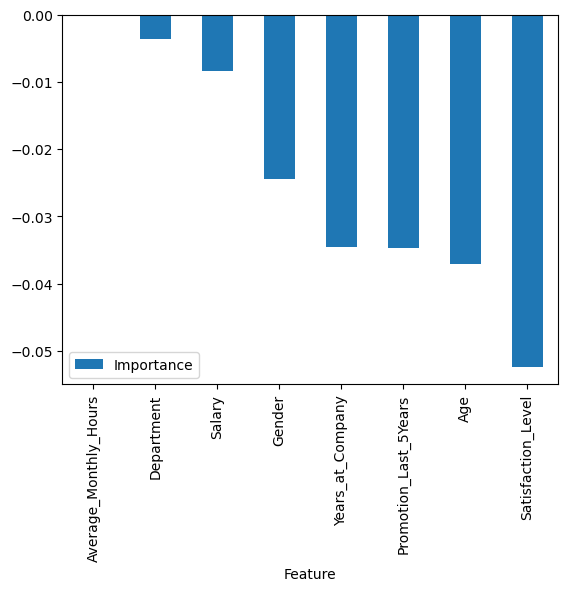

In [63]:
# Compute permutation importance
perm_importance = permutation_importance(best_svm_model, 
                                         X_test, 
                                         y_test, 
                                         scoring="recall", 
                                         n_repeats=100)

# Create DataFrame
perm_importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

perm_importance_df.set_index("Feature").plot(kind="bar")
_ = plt.axhline(0, color='black', linewidth=.5)

### SHAP

In [53]:
# Get the preprocessor step from the pipeline and transform X_test
preprocessor = best_svm_model.named_steps["preprocessor"]
X_test_transformed = preprocessor.transform(X_test)

# Get feature names after preprocessing
feature_names = best_svm_model.named_steps["preprocessor"].get_feature_names_out()

# Use KernelExplainer for SHAP (since SVM is not tree-based)
explainer = shap.KernelExplainer(best_svm_model.named_steps["classifier"].predict_proba, X_test_transformed)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_transformed)

Using 199 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 199/199 [05:12<00:00,  1.57s/it]


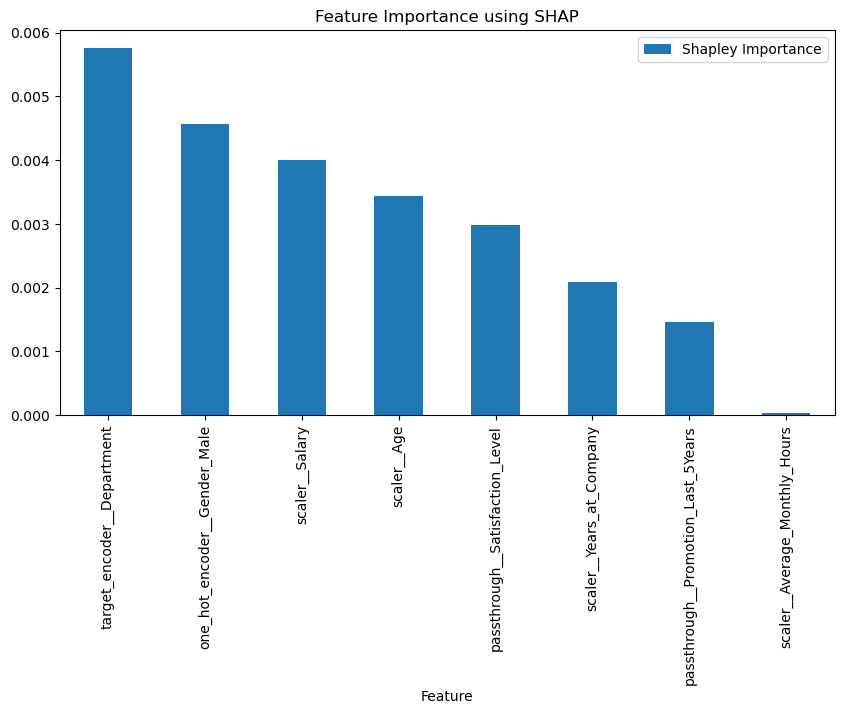

In [56]:
# Convert SHAP values to a DataFrame for plotting
shap_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Shapley Importance": np.mean(np.abs(shap_values[..., 1]), axis=0)  # Absolute importance for positive class
}).sort_values(by="Shapley Importance", ascending=False)

# Plot the feature importance
shap_importance_df.set_index("Feature").plot(kind="bar", figsize=(10, 5))
plt.axhline(0, color="black", linewidth=0.5)
plt.title("Feature Importance using SHAP")
plt.show()

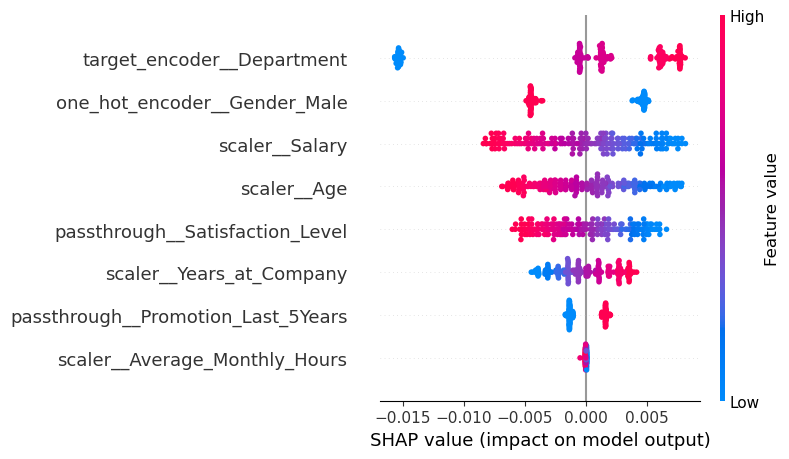

In [57]:
# SHAP Summary Plot
shap.summary_plot(shap_values[..., 1], X_test_transformed, feature_names=feature_names)

## Model saving

In [58]:
# Save the model
joblib.dump(best_svm_model, "attrition_classification_model.pkl")

['attrition_classification_model.pkl']